In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

import textacy
import spacy
from collections import Counter

In [ ]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "archive"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()


Numero di file CSV trovati: 7
Caricamento file 1/7 → CEAS_08.csv
Caricamento file 2/7 → Enron.csv
Caricamento file 3/7 → Ling.csv
Caricamento file 4/7 → Nazario.csv
Caricamento file 5/7 → Nigerian_Fraud.csv
Caricamento file 6/7 → phishing_email.csv
Caricamento file 7/7 → SpamAssasin.csv


,sender,receiver,date,subject,body,label,urls,text_combined
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1.0,NaN
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1.0,NaN
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1.0,NaN
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1.0,NaN
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1.0,NaN


In [3]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164972 entries, 0 to 164971
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sender         49529 non-null   object 
 1   receiver       47768 non-null   object 
 2   date           49377 non-null   object 
 3   subject        82139 non-null   object 
 4   body           82485 non-null   object 
 5   label          164972 non-null  int64  
 6   urls           49860 non-null   float64
 7   text_combined  82486 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 10.1+ MB


Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'text_combined'],
      dtype='object')

label
1    85782
0    79190
Name: count, dtype: int64


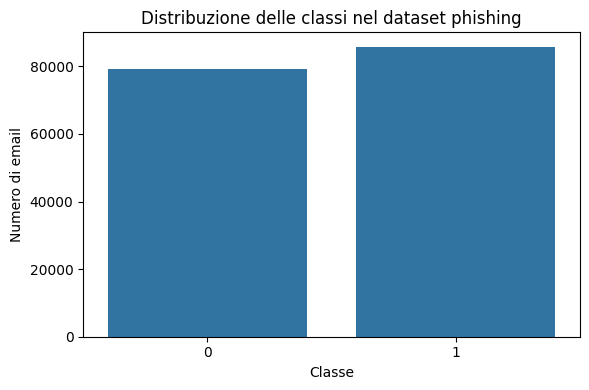

In [4]:
print(data["label"].value_counts())
category_counts = data["label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(
    x=category_counts.index,
    y=category_counts.values
)

plt.xlabel("Classe")
plt.ylabel("Numero di email")
plt.title("Distribuzione delle classi nel dataset phishing")

plt.tight_layout()
plt.show()

In [5]:
# rimozione duplicati
data.drop_duplicates(inplace=True)

# rimozione righe con testo mancante
data = data.dropna(subset=["body"])   
print(data["label"].value_counts())

label
1    42890
0    39595
Name: count, dtype: int64


KPE

In [ ]:
# PREprocessing testuale per Keyphrase Extraction
# Regex per email e URL
RE_URL = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|mailto:)[^\s<>"]+|(?:[a-z0-9.\-]+[.][a-z]{2,})(/[^\s<>"]*)?)\b""")
RE_EMAIL = re.compile(r"(?i)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b")
RE_CTRL = re.compile(r"[\x00-\x1f\x7f-\x9f]")  # caratteri di controllo
RE_WS = re.compile(r"\s+")
RE_HTML_TAGS = re.compile(r"<[^>]+>")  

# Funzione di preprocessing conservativo per Keyphrase Extraction
def preprocess_for_kpe(text: str, mask_ioc: bool = True) -> str:
    if not isinstance(text, str):
        return ""

    # Normalizzazione base
    t = text.replace("\r\n", "\n").replace("\r", "\n")
    t = RE_CTRL.sub(" ", t)

    # Rimozione HTML grezzo (se presente)
    t = RE_HTML_TAGS.sub(" ", t)

    # Gestione IOC: URL / email
    if mask_ioc:
        t = RE_URL.sub(" <URL> ", t)
        t = RE_EMAIL.sub(" <EMAIL> ", t)
    else:
        t = RE_URL.sub(r" \1 ", t)
        t = RE_EMAIL.sub(r" \g<0> ", t)

    # Rimozione di linee "quasi vuote" e quoting ripetuto, non elimina contenuto, riduce solo accumuli
    lines = []
    for line in t.split("\n"):
        line_stripped = line.strip()
        if not line_stripped:
            continue
        # scarta righe composte quasi solo da simboli
        if len(line_stripped) >= 6 and len(set(line_stripped)) <= 3:
            continue
        lines.append(line_stripped)
    t = " ".join(lines)

    # Normalizzazione spazi
    t = RE_WS.sub(" ", t).strip()

    return t

# Applica al dataframe
data["body_kpe"] = data["body"].apply(lambda x: preprocess_for_kpe(x, mask_ioc=True))

# Controllo rapido
data[["label", "body", "body_kpe"]].head(3)


,label,body,body_kpe
0,1,"Buck up, your troubles caused by small dimensi...","Buck up, your troubles caused by small dimensi..."
1,1,\nUpgrade your sex and pleasures with these te...,Upgrade your sex and pleasures with these tech...
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...


In [14]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 655.4 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 1.0 MB/s eta 0:00:13
      --------------------------------------- 0.3/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.4/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.5/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.6/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.7/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.7/12.8 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 1.6 MB/s eta 0:00:08
     --- ------------------------------------ 1.0/12.8 MB 1.7 MB


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
data["body_kpe"].str.len().describe()


count    8.248500e+04
mean     1.577149e+03
std      1.631554e+04
min      0.000000e+00
25%      2.880000e+02
50%      6.840000e+02
75%      1.804000e+03
max      4.473803e+06
Name: body_kpe, dtype: float64

In [ ]:
# filtro outlier
MAX_CHARS = 50000
lens = data["body_kpe"].fillna("").astype(str).str.len()
data_kpe = data.loc[lens <= MAX_CHARS].copy()

print(f"Righe totali: {len(data)} | Righe usate per KPE (<= {MAX_CHARS}): {len(data_kpe)}")

# pipeline spaCy 
nlp = textacy.load_spacy_lang("en_core_web_sm")

# estrazione KPE su Doc
def kpe_textrank_from_doc(doc, topn: int = 5):
    kps = [
        term for term, score in textacy.extract.keyterms.textrank(
            doc,
            normalize="lemma",
            topn=topn,
        )
    ]
    # filtro placeholder introdotti nel preprocessing
    return [kp for kp in kps if "URL" not in kp.upper() and "EMAIL" not in kp.upper()]

# applicazione batch su tutte le email filtrate
texts = data_kpe["body_kpe"].fillna("").astype(str).tolist()

kpe_out = []
for doc in nlp.pipe(texts, batch_size=64):
    # se il doc è vuoto, nessuna KPE
    if not doc or not doc.text.strip():
        kpe_out.append([])
    else:
        kpe_out.append(kpe_textrank_from_doc(doc, topn=5))

data_kpe["kpe_textrank_top5"] = kpe_out

data_kpe[["label", "kpe_textrank_top5"]].head(10)


Righe totali: 82485 | Righe usate per KPE (<= 50000): 82404


,label,kpe_textrank_top5
0,1,"[small dimension, Nazi tank, trouble, lover]"
1,1,"[sex, technique, pleasure]"
2,1,[= = = = = = = = = = = = = = = = = = = = = = =...
3,0,[= = = = = = = = = = = = = = = = = = = = = = =...
4,1,[]
5,1,"[C mo l cfd IC eym K, Yo wu urS mo, rc ebo eFo..."
6,1,"[fake swiss Men, Popular Panerai, Replica Watc..."
7,1,[= = = = = = = = = = = = = = = = = = = = = = =...
8,0,"[assignee, otherbugsdependingo|, nthis|, |Remo..."
9,1,[= = = = = = = = = = = = = = = = = = = = = = =...


In [ ]:
# funzione di validazione keyphrase
def is_valid_keyphrase(kp: str) -> bool:
    if not kp or not isinstance(kp, str):
        return False

    kp = kp.strip()

    # elimina placeholder
    if "URL" in kp.upper() or "EMAIL" in kp.upper():
        return False

    # elimina sequenze di simboli
    if re.fullmatch(r"[\W_]+", kp):
        return False

    # almeno 2 lettere alfabetiche
    if len(re.findall(r"[A-Za-z]", kp)) < 2:
        return False

    # troppi caratteri non alfabetici
    non_alpha_ratio = len(re.findall(r"[^A-Za-z\s]", kp)) / max(len(kp), 1)
    if non_alpha_ratio > 0.4:
        return False

    # lunghezza ragionevole
    if len(kp) > 60:
        return False

    return True


In [ ]:
def kpe_textrank_from_doc(doc, topn=5):
    kps = [
        term for term, score in textacy.extract.keyterms.textrank(
            doc,
            normalize="lemma",
            topn=topn * 3 
        )
    ]

    # filtro forte
    kps = [kp for kp in kps if is_valid_keyphrase(kp)]

    return kps[:topn]


In [25]:
# campiona qualche email per classe e mostra keyphrase
SAMPLE_N = 5

cols = ["label", "body_kpe", "kpe_textrank_top5"]
display(
    data_kpe.loc[data_kpe["label"] == 1, cols].sample(SAMPLE_N, random_state=42)
)
display(
    data_kpe.loc[data_kpe["label"] == 0, cols].sample(SAMPLE_N, random_state=42)
)


,label,body_kpe,kpe_textrank_top5
24834,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,[= = = = = = = = = = = = = = = = = = = = = = =...
24191,1,Not all p pfx en hqf is en mh larg wf ing met ...,"[lar ws ge p unm eni, lar cv ge onl, mb lar zt..."
5144,1,Buy the Patek Philippe watch and know everythi...,"[luxurious costume replica watch, Patek Philip..."
72806,1,Your address is up-to-date ACCOUNT ACTIVITY: D...,"[American Express ® account, American Express ..."
60200,1,"hello , young lovers ! : ) sinalyomm ' e '","[young lover, sinalyomm]"


,label,body_kpe,kpe_textrank_top5
37664,0,<URL> ------- Additional Comments From user7@ ...,"[additional comment, assignee, user7@, 07:55]"
36008,0,">> - for experienced users (Barry, skip, etc) ...","[visible ~/local symlink, dependent ~/local, S..."
19101,0,Nick Coghlan wrote: > I believe the list of in...,"[Dev mailing list, api design, Python version,..."
50624,0,should i cancel my trip ? i don ' t mind at al...,[louise kitchen chief operating officer enron ...
61175,0,i think it is time that you have someone inven...,"[critical one, business unit, project, daily o..."


In [ ]:
# una keyphrase per riga
df_kp = data_kpe[["label", "kpe_textrank_top5"]].explode("kpe_textrank_top5").dropna()

# normalizza minuscolo per contare varianti minor
df_kp["kp_norm"] = df_kp["kpe_textrank_top5"].str.lower().str.strip()

# top 30 per classe
top_phish = (
    df_kp[df_kp["label"] == 1]["kp_norm"]
    .value_counts()
    .head(30)
    .reset_index()
    .rename(columns={"index": "keyphrase", "kp_norm": "count"})
)

top_legit = (
    df_kp[df_kp["label"] == 0]["kp_norm"]
    .value_counts()
    .head(30)
    .reset_index()
    .rename(columns={"index": "keyphrase", "kp_norm": "count"})
)

top_phish, top_legit


(                                                count  count
 0                               cable news network lp   2930
 1   = = = = = = = = = = = = = = = = = = = = = = = ...   2930
 2                                               + = +   2930
 3                                  custom alert alert   1406
 4                                 time warner company   1383
 5                                  cable news network   1255
 6                                       personal life   1022
 7                                  n. dakota oil boom    987
 8       republican presidential candidate john mccain    987
 9                      smoke forces emergency landing    981
 10                          plane evacuates passenger    981
 11                       defendant fakes heart attack    962
 12                   anthrax suspect apparent suicide    962
 13                                                aug    940
 14                                   replica classics    457
 15     

In [ ]:
# conteggi globali per classe
c_phish = Counter(df_kp[df_kp["label"] == 1]["kp_norm"])
c_legit = Counter(df_kp[df_kp["label"] == 0]["kp_norm"])

vocab = set(c_phish) | set(c_legit)
alpha = 1.0  # smoothing Laplace

n_phish = sum(c_phish.values())
n_legit = sum(c_legit.values())

rows = []
for kp in vocab:
    p = (c_phish.get(kp, 0) + alpha) / (n_phish + alpha * len(vocab))
    q = (c_legit.get(kp, 0) + alpha) / (n_legit + alpha * len(vocab))
    log_odds = np.log(p / q)
    rows.append((kp, log_odds, c_phish.get(kp, 0), c_legit.get(kp, 0)))

df_diff = pd.DataFrame(rows, columns=["keyphrase", "log_odds_phish_vs_legit", "count_phish", "count_legit"])
df_diff = df_diff.sort_values("log_odds_phish_vs_legit", ascending=False)

# top 30 
df_diff.head(30)


,keyphrase,log_odds_phish_vs_legit,count_phish,count_legit
111577,cable news network lp,7.988061,2930,0
131538,+ = +,7.988061,2930,0
97265,custom alert alert,7.254177,1406,0
22644,personal life,6.935457,1022,0
143050,republican presidential candidate john mccain,6.900645,987,0
124287,n. dakota oil boom,6.900645,987,0
64308,plane evacuates passenger,6.894554,981,0
119709,smoke forces emergency landing,6.894554,981,0
44413,anthrax suspect apparent suicide,6.875016,962,0
46575,defendant fakes heart attack,6.875016,962,0


NER

In [7]:
# Preprocessing per NER 
RE_URL = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|mailto:)[^\s<>"]+|(?:[a-z0-9.\-]+[.][a-z]{2,})(/[^\s<>"]*)?)\b""")
RE_EMAIL = re.compile(r"(?i)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b")
RE_CTRL = re.compile(r"[\x00-\x1f\x7f-\x9f]")  # caratteri di controllo
RE_WS = re.compile(r"\s+")
RE_HTML_TAGS = re.compile(r"<[^>]+>")  

def preprocess_for_ner(text: str) -> str:
    if not isinstance(text, str):
        return ""

    t = text.replace("\r\n", "\n").replace("\r", "\n")
    t = RE_CTRL.sub(" ", t)
    t = RE_HTML_TAGS.sub(" ", t)

    # mantiene URL/email, ma separa per tokenizzazione
    t = RE_URL.sub(r" \1 ", t)
    t = RE_EMAIL.sub(r" \g<0> ", t)

    # elimina righe rumorose (separatori)
    lines = []
    for line in t.split("\n"):
        line_stripped = line.strip()
        if not line_stripped:
            continue
        if len(line_stripped) >= 6 and len(set(line_stripped)) <= 3:
            continue
        lines.append(line_stripped)

    t = " ".join(lines)
    t = RE_WS.sub(" ", t).strip()
    return t

data["body_ner"] = data["body"].apply(preprocess_for_ner)
data[["label", "body_ner"]].head(3)


,label,body_ner
0,1,"Buck up, your troubles caused by small dimensi..."
1,1,Upgrade your sex and pleasures with these tech...
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...


In [8]:
data["body_ner"].str.len().describe()

count    8.248500e+04
mean     1.703122e+03
std      1.682850e+04
min      0.000000e+00
25%      3.020000e+02
50%      7.130000e+02
75%      1.861000e+03
max      4.553665e+06
Name: body_ner, dtype: float64

In [9]:
MAX_CHARS_NER = 50000
mask_ok = data["body_ner"].fillna("").astype(str).str.len() <= MAX_CHARS_NER
data_ner = data.loc[mask_ok].copy()

nlp = spacy.load("en_core_web_sm")

RE_URL = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|mailto:)[^\s<>"]+)\b""")
RE_EMAIL = re.compile(r"(?i)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b")

def ner_spacy(text: str):
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def ner_ioc(text: str):
    if not isinstance(text, str):
        return []
    out = []
    out += [(m.group(1), "URL") for m in RE_URL.finditer(text)]
    out += [(m.group(0), "EMAIL") for m in RE_EMAIL.finditer(text)]
    return out

data_ner["ner_spacy"] = data_ner["body_ner"].apply(ner_spacy)
data_ner["ner_ioc"]   = data_ner["body_ner"].apply(ner_ioc)
data_ner["ner_all"]   = data_ner.apply(lambda r: r["ner_spacy"] + r["ner_ioc"], axis=1)

data_ner[["label", "ner_all"]].head(10)

,label,ner_all
0,1,"[(Buck, PERSON), (Nazi, NORP), (http://whitedo..."
1,1,"[(http://www.brightmade.com, URL)]"
2,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."
3,0,"[(TLD, ORG), (http://en.wikipedia.org/wiki/.so..."
4,1,"[(WelcomeFastShippingCustomerSupport, GPE), (h..."
5,1,"[(Yo wu urS mo, PERSON)]"
6,1,"[(Swiss Men's, ORG), (Ladie, PERSON), (Replica..."
7,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."
8,0,[(http://issues.apache.org/SpamAssassin/show_b...
9,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."


In [ ]:
def normalize_ents(ents):
    out = []
    seen = set()
    for txt, lab in ents:
        txt_norm = " ".join(str(txt).split()).strip()   # normalizza spazi
        if not txt_norm:
            continue
        key = (txt_norm.lower(), lab)                  # considera ad es CNN e cnn uguali
        if key in seen:                                # mantiene una sola occorrenza per mail
            continue
        seen.add(key)
        out.append((txt_norm, lab))
    return out

data_ner["ner_all_norm"] = data_ner["ner_all"].apply(normalize_ents)
data_ner[["label", "ner_all_norm"]].head(10)


,label,ner_all_norm
0,1,"[(Buck, PERSON), (Nazi, NORP), (http://whitedo..."
1,1,"[(http://www.brightmade.com, URL)]"
2,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."
3,0,"[(TLD, ORG), (http://en.wikipedia.org/wiki/.so..."
4,1,"[(WelcomeFastShippingCustomerSupport, GPE), (h..."
5,1,"[(Yo wu urS mo, PERSON)]"
6,1,"[(Swiss Men's, ORG), (Ladie, PERSON), (Replica..."
7,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."
8,0,[(http://issues.apache.org/SpamAssassin/show_b...
9,1,"[(DAILY, ORG), (10, CARDINAL), (1, 2008, DATE)..."


In [ ]:
# Funzione per contare etichette NER per ogni email
def count_labels(ents):
    c = Counter()
    for _, lab in ents:
        c[lab] += 1
    return c

data_ner["ner_label_counts"] = data_ner["ner_all_norm"].apply(count_labels)


In [14]:
# porta i Counter a colonne
label_df = pd.DataFrame(data_ner["ner_label_counts"].tolist()).fillna(0)

# unisci la label phishing/non-phishing
label_df["label"] = data_ner["label"].values

# media dei conteggi per classe
label_means = label_df.groupby("label").mean().sort_index()
label_means


,PERSON,NORP,URL,ORG,CARDINAL,DATE,TIME,LOC,ORDINAL,GPE,EMAIL,MONEY,EVENT,FAC,QUANTITY,PERCENT,PRODUCT,WORK_OF_ART,LAW,LANGUAGE
label,,,,,,,,,,,,,,,,,,,,
0,4.508438,0.351036,1.398148,3.648154,4.027503,3.297978,0.749842,0.111226,0.241556,1.160413,0.036485,0.500367,0.048782,0.075779,0.120208,0.150773,0.172026,0.177593,0.038206,0.036510
1,1.932575,0.269235,2.043007,2.368286,2.539730,1.297945,0.246356,0.102922,0.136064,1.019171,0.074236,0.651212,0.071530,0.030109,0.094829,0.333652,0.068055,0.043193,0.039695,0.005457


In [ ]:
# conteggi globali delle entità NER per email di phishing
phish_df = data_ner[data_ner["label"] == 1]

counter_all = Counter()

for ents in phish_df["ner_all_norm"]:
    for txt, lab in ents:
        counter_all[(txt.lower(), lab)] += 1

top_all = pd.DataFrame(
    [(txt, lab, cnt) for (txt, lab), cnt in counter_all.most_common(30)],
    columns=["entity", "entity_type", "count"]
)

top_all


,entity,entity_type,count
0,one,CARDINAL,7824
1,2,CARDINAL,6062
2,1,CARDINAL,5802
3,3,CARDINAL,5557
4,8,CARDINAL,5167
5,5,CARDINAL,5084
6,4,CARDINAL,4641
7,cnn,ORG,4543
8,georgia,GPE,4420
9,atlanta,GPE,4393
